In [1]:
from ds.physio.general import PhysioNetClinicalDataset
import warnings, torch, os
import pandas as pd
import torch.utils.data as data
from utils.train import get_dataloader_g, collate_fn
from utils.device import clean_memory_get_device
from utils.plot import plot_train
from our_improved_v4_without_auto.builder import OurImproved_v4_WithoutAuto
import math
import numpy as np
from IPython.display import clear_output
from torchvision import models
from tqdm import tqdm

pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore")

c:\Users\mike8\anaconda3\envs\pytorch\lib\site-packages\torch\utils\_contextlib.py:125: UserWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  warnings.warn("Decorating classes is deprecated and will be disabled in "


In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:256"
device = clean_memory_get_device()
# device = torch.device("cpu")
if torch.cuda.is_available():
    print(torch.cuda.memory_summary())

This notebook will running on device: [CUDA]
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large 

In [3]:
image_size = 128
batch_size = 128
epochs = 100

# def collate_fn(x):
#     imgs = [i[0] for i in x]
#     clinical = torch.stack([i[1] for i in x])
#     return imgs, clinical

train_d = data.DataLoader(
    PhysioNetClinicalDataset(split_str="train", image_size=image_size),
    batch_size=batch_size,
    shuffle=True,
    collate_fn=None,
    generator=get_dataloader_g(0),
    drop_last=False,
)

In [4]:
learner = OurImproved_v4_WithoutAuto(
    models.resnet18,
    clinical_input_dim=train_d.dataset.num_clinical_features(),
    image_size=image_size,
    # hidden_layer="avgpool",  # layer name where output is hidden dimension. this can also be an integer specifying the index of the child
    # project_hidden=True,  # use projection head
    dim=512,  # output size of resnet18, to match size in the simclr.
    pred_dim=128,
)

In [5]:
# # load 100 epoch model
# cp = torch.load(os.path.join("checkpoints", "our_alt", "model"), map_location=device)
# learner.load_state_dict(cp["model"], strict=True)

In [6]:
def get_number(x):
    try:
        return float(x)
    except:
        return None

In [7]:
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts

optimizer = torch.optim.AdamW(
    params=[p for p in learner.parameters() if p.requires_grad],
    lr=3e-4,
)

# scheduler = StepLR(
#     optimizer,
#     step_size=1,
#     gamma=0.85,
# )
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=math.ceil(len(train_d.dataset) / batch_size)
    * epochs,  # 286,817 is the size of the training dataset. (https://paperswithcode.com/dataset/cnn-daily-mail-1)
    eta_min=1e-8,
)
# scheduler = CosineAnnealingWarmRestarts(
#     optimizer,
#     T_0=10,
#     T_mult=2,
# )

In [8]:
def get_mean_loss_dict(loss_dict: list[dict[str, float]]):
    keys = loss_dict[0].keys()
    out_dict = {k: [i[k] for i in loss_dict] for k in keys}
    out_dict = {k: np.mean(v) for k, v in out_dict.items()}
    return out_dict

In [9]:
def train_one_epoch(
    model,
    optimizer,
    data_loader,
    device,
    epoch,
    max_norm=0,
    lr_scheduler=None,
):
    model.to(device)
    model.train()
    iters = math.ceil(len(data_loader.dataset) / train_d.batch_size)

    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, iters - 1)
        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    losses = []
    loss_dict = []

    is_wr = (not lr_scheduler is None) and isinstance(
        lr_scheduler, torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
    )
    
    pbar = tqdm(total=len(data_loader))
    
    for i, (img, tab) in enumerate(data_loader):
        loss, l_d = model(img.to(device), tab.to(device))
        optimizer.zero_grad()
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()

        # if is consinwr, step every batch
        if (not lr_scheduler is None) and is_wr:
            # print("CosineAnnealingWarmRestarts learning rate update.")
            lr_scheduler.step(epoch + i / iters)
        elif epoch == 0:
            # print("Warmup scheduler stepping")
            lr_scheduler.step()

        losses.append(loss.item())
        loss_dict.append(l_d)
        pbar.update()

    pbar.close()

    # scheduler step after an epoch if not cosinewr
    if epoch != 0 and (lr_scheduler is not None) and not is_wr:
        # print("Epoch scheduler stepping")
        lr_scheduler.step()

    return losses, {**get_mean_loss_dict(loss_dict), "lr": lr_scheduler.get_last_lr()}

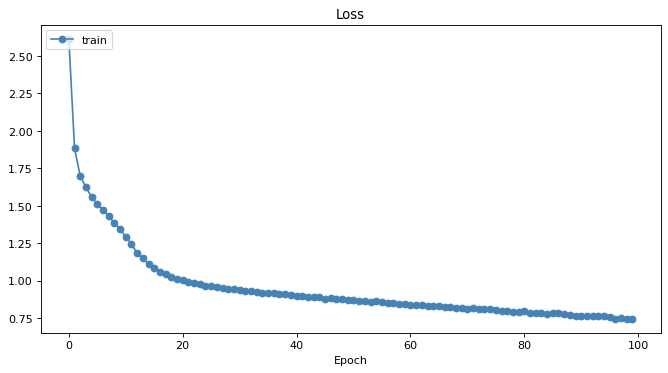

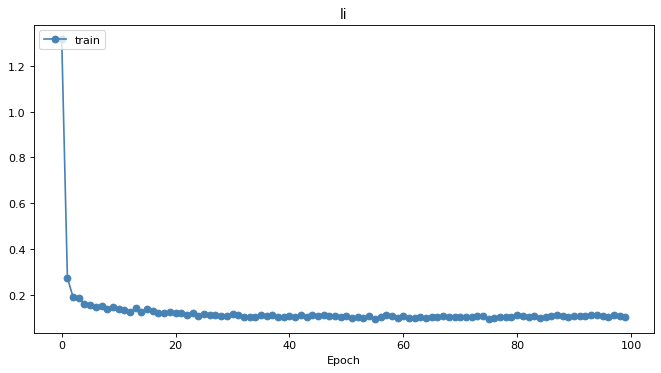

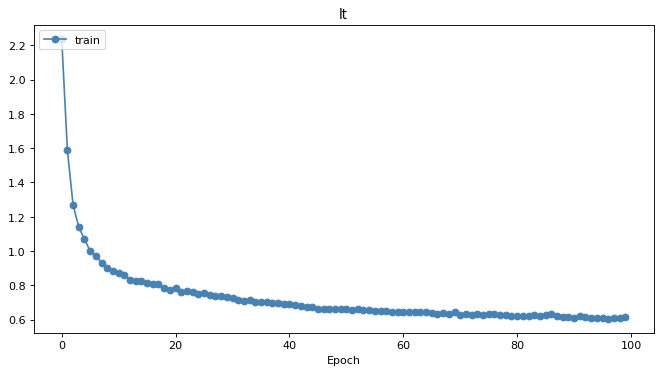

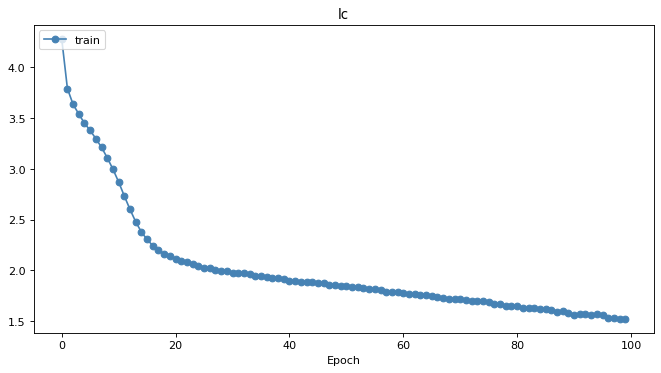

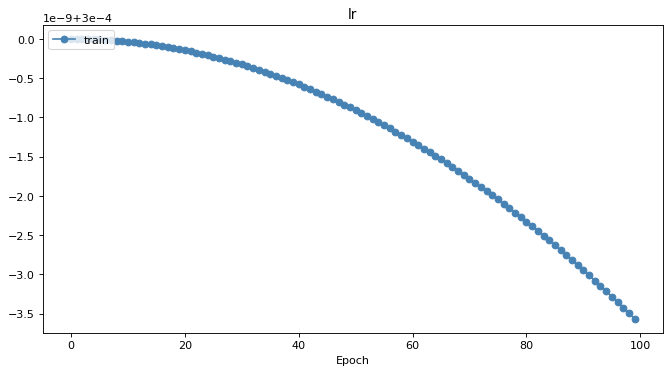

In [10]:
train_losses = []
sub_losses = []

for epoch in range(epochs):
    train_l, sub_l = train_one_epoch(
        learner,
        optimizer,
        train_d,
        device,
        epoch,
        max_norm=1,
        lr_scheduler=scheduler,
    )
    sub_losses.append(sub_l)
    train_losses.append(np.mean(train_l))
    clear_output()
    plot_train(train_losses, title="Loss")
    for k in sub_losses[0].keys():
        plot_train([s[k] for s in sub_losses], title=k)


In [11]:
model_path = "our_improved_v4_without_auto" 

saving_dict = {"model": learner.state_dict()}
if optimizer:
    saving_dict["optimizer"] = optimizer.state_dict()

if scheduler:
    saving_dict['scheduler'] = scheduler.state_dict()

saving_folder = os.path.join("checkpoints", model_path)
os.makedirs("checkpoints", exist_ok=True)
os.makedirs(saving_folder, exist_ok=True)
torch.save(
    saving_dict,
    os.path.join("checkpoints", model_path, "model"),
)

# learner.net.net.state_dict() # resnet here.